# Classifying Ailemnts using Medical Text and Speech Phrases

The dataset contains brief audio recordings and transcripts of issues related to 25 different ailments. In this kernal, I'll do a little bit of pre-processing and then categorize the ailments using the text and then the speech recording files.

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import IPython
import matplotlib.pyplot as plt
import librosa
from nltk.corpus import stopwords 
import random
from scipy.io import wavfile
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
import os
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from tensorflow.python.keras.optimizer_v2.adam import Adam
from nltk.util import ngrams
from keras.callbacks import LearningRateScheduler
import nltk
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import glob
from PIL import Image

Using TensorFlow backend.


## Import Data

First things first, import the data and select the relevant columns. 
- `Prompt` will be used as the classification target.

- `file_name` and `phrase` will be used as features in two neural networks. 

- `overall_quality_of_the_audio` may be relevant for filtering bad quality audio later on. 

In [2]:
import_df = pd.read_csv('../input/medical-speech-with-spectrograms/Medical Speech, Transcription, and Intent/overview-of-recordings.csv')
import_df = import_df[['file_name','phrase','prompt','overall_quality_of_the_audio','speaker_id']]
print(import_df.shape)
import_df.head()

(6661, 5)


,file_name,phrase,prompt,overall_quality_of_the_audio,speaker_id
0,1249120_43453425_58166571.wav,When I remember her I feel down,Emotional pain,3.33,43453425
1,1249120_43719934_43347848.wav,When I carry heavy things I feel like breaking...,Hair falling out,3.33,43719934
2,1249120_43719934_53187202.wav,there is too much pain when i move my arm,Heart hurts,3.33,43719934
3,1249120_31349958_55816195.wav,My son had his lip pierced and it is swollen a...,Infected wound,3.33,31349958
4,1249120_43719934_82524191.wav,My muscles in my lower back are aching,Infected wound,4.67,43719934


### Sample 

I'll randomly sample the dataframe and display the transcription, the classification and the audio file in a player to get an idea of what the neural network will be figuring out. 

In [3]:
test_num = random.randrange(0, len(import_df))
test_file_name = import_df.loc[test_num, 'file_name']
print(import_df.loc[test_num, 'prompt'] + '\n' + import_df.loc[test_num, 'phrase'])
display_audio_file = f'../input/medical-speech-with-spectrograms/Medical Speech, Transcription, and Intent/recordings/test/{test_file_name}'
IPython.display.Audio(display_audio_file)

Foot ache
My foot had been aching since last Tuesday.


## Data Exploration

First, I'll visualize the target variable to get an idea what we're working with. 

Number of unique prompts :  25


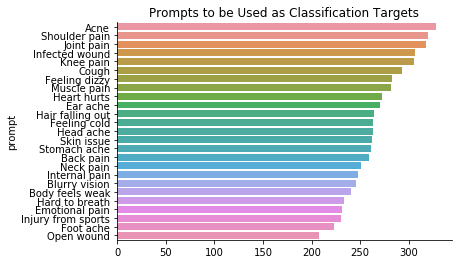

In [4]:
grouped_series = import_df.groupby('prompt').agg('count')['speaker_id'].sort_values(ascending=False)
unique_prompts = len(import_df['prompt'].unique())
print("Number of unique prompts : ", unique_prompts)
sns.barplot(grouped_series.values, grouped_series.index)
plt.title('Prompts to be Used as Classification Targets')
sns.despine()

We can also plot the distribution of the reported audio quality. It looks the values are on the higher end of the 5-point scale so we won't have to filter anything. We can just drop the column now. 

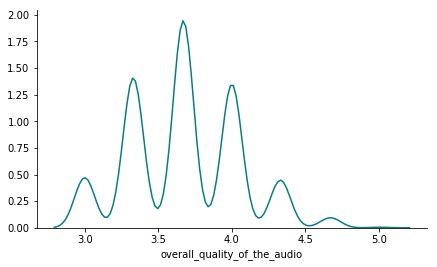

In [5]:
preprocess_df = import_df.drop('overall_quality_of_the_audio', axis=1)

fig = plt.figure(figsize=(7,4))
sns.distplot(import_df['overall_quality_of_the_audio'], hist=False, color='teal')
sns.despine()

I'm removing contractions and then creating a word dictionary with all the words from the phrases.

In [6]:
stop_words = set(stopwords.words('english')) 
word_dict = {}
preprocess_df['phrase'] = [i.lower() for i in preprocess_df['phrase']]
preprocess_df['phrase'] = [i.replace('can\'t', 'can not') for i in preprocess_df['phrase']]
preprocess_df['phrase'] = [i.replace('i\'m', 'i am') for i in preprocess_df['phrase']]
preprocess_df['phrase'] = [i.replace('i\'ve', 'i have') for i in preprocess_df['phrase']]
preprocess_df['phrase'] = [' '.join([j for j in i.split(' ') if j not in stop_words]) for i in preprocess_df['phrase']]

for phrase in preprocess_df['phrase']:
    for word in phrase.split(' '):
        word = word.lower()
        if word in stop_words or word == '':
            pass
        elif word not in word_dict:
            word_dict[word] = 1
        else:
            word_dict[word] += 1
            
sorted_word_list = sorted(word_dict.items(), key=lambda kv: kv[1], reverse=True)

Below I'll show the `n` most common words in the phrases. 

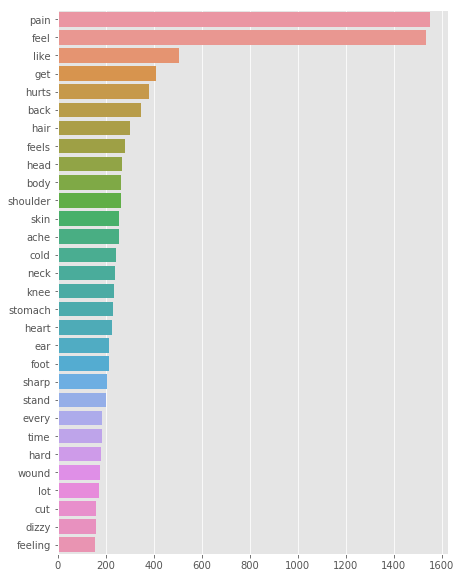

In [7]:
n = 30
fig = plt.figure(figsize=(7,10))
plt.style.use('ggplot')
sns.barplot([i[1] for i in sorted_word_list[:n]], [i[0] for i in sorted_word_list[:n]])

With inspiration from [this](https://www.kaggle.com/nicapotato/explore-the-spooky-n-grams-wordcloud-bayes#N-Grams) kernal, I define some helper functions to create a dataframe of the most common ngrams. 

In [8]:
def get_ngrams(text, n):
    n_grams = ngrams((text), n)
    return [' '.join(i) for i in n_grams]

def gramfreq(phrases, n, num):
    ngram_dict = {}
    for phrase in phrases:
        result = get_ngrams(phrase.split(' '),n)
        result_count = Counter(result)
        for gram in result_count.keys():
            if gram not in ngram_dict.keys():
                ngram_dict[gram] = 1
            else:
                ngram_dict[gram] += 1
    df = pd.DataFrame.from_dict(ngram_dict, orient='index')
    df = df.rename(columns={'index':'words', 0:'frequency'}) # Renaming index column name
    return df.sort_values(["frequency"],ascending=[0])[:num]

def gram_table(x, ns, result_length):
    output = pd.DataFrame(index=None)
    for n in ns:
        table = pd.DataFrame(gramfreq(x, n, result_length).reset_index())
        table.columns = [f"{n}-Gram",f"{n}-Occurence"]
        output = pd.concat([output, table], axis=1)
    return output

gram_df = gram_table(x=preprocess_df['phrase'], ns=[1,2,3,4], result_length=30)
gram_df.head(20)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: generator 'ngrams' raised StopIteration
  This is separate from the ipykernel package so we can avoid doing imports until


,1-Gram,1-Occurence,2-Gram,2-Occurence,3-Gram,3-Occurence,4-Gram,4-Occurence
0,feel,1521,feel pain,316,body feels weak,52,start feel dizzy light-headed,35
1,pain,1472,sharp pain,181,feel great pain,51,stand quickly start feel,35
2,like,495,feel like,171,feel sharp pain,48,quickly start feel dizzy,35
3,get,381,feel dizzy,139,start feel dizzy,44,apply pain relief cream,27
4,hurts,380,feels like,134,feel pain knee,40,hair falling combing it.,23
5,back,348,hair falling,102,feel pain back,37,chronic disease hair follicles,21
6,,318,body feels,82,feel like something,37,disease hair follicles sebaceous,21
7,feels,272,every time,79,feel pain neck,36,body feels weak although,20
8,body,265,pain stomach,79,feel dizzy light-headed,35,pain bicep. tried apply,18
9,shoulder,264,great pain,78,quickly start feel,35,bicep. tried apply pain,18


We can plot the resulting df for a better picture.

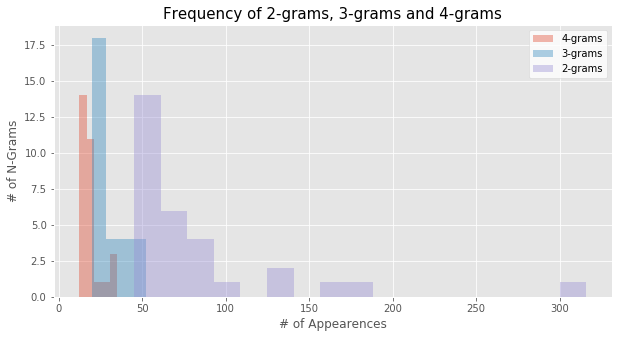

In [9]:
fig = plt.figure(figsize=(10,5))
plt.title('Frequency of 2-grams, 3-grams and 4-grams', fontsize=15)

sns.distplot(gram_df['4-Occurence'], kde=False, label = '4-grams')
sns.distplot(gram_df['3-Occurence'], kde=False, label = '3-grams')
sns.distplot(gram_df['2-Occurence'], kde=False, label = '2-grams')

plt.ylabel('# of N-Grams')
plt.xlabel('# of Appearences')
plt.legend(facecolor='white')

### Data Pre-processing

#### Create training, test, validation indices

We'll group the examples by the folder the .wav file is in. 

In [10]:
base_dir = '../input/medical-speech-with-spectrograms/Medical Speech, Transcription, and Intent/recordings/'

train_files = [base_dir + 'train/' + i for i in os.listdir(base_dir + 'train')]
val_files = [base_dir + 'validate/' + i for i in os.listdir(base_dir + 'validate')]
test_files = [base_dir + 'test/' + i for i in os.listdir(base_dir + 'test')]

all_files = train_files + test_files + val_files
len(all_files)

6661

#### Text Features

The data from Kaggle was squeaky clean so there's very little in terms of real "pre" processing. We removed contractions earlier and that's all we're going to do.

For data processing, I'm going to fit an [NLTK tokenzier](https://www.nltk.org/api/nltk.tokenize.html) object on the phrases, use that tokenzier to convert them to integer sequences of their word index and then pad the sequences so they'll all be the same length.

In [11]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(preprocess_df['phrase'])
word_index = tokenizer.word_index
vocab_size = len(word_index)
print(f'vocab_size : {vocab_size}')

phrases_seq = tokenizer.texts_to_sequences(preprocess_df['phrase'])
padded_phrases_seq = pad_sequences(phrases_seq, padding='post')
padded_phrases_seq = np.asarray(padded_phrases_seq)
max_seq_length = padded_phrases_seq.shape[0]
print("padded_phrases_seq shape : ", padded_phrases_seq.shape)

vocab_size : 1070
padded_phrases_seq shape :  (6661, 14)


We can randomly sample our data to look at the original phrase, the transformed phrase and the padded sequence version of it.

In [12]:
random_phrase_num = random.randrange(0, len(preprocess_df))
random_import_phrase = import_df.loc[random_phrase_num, 'phrase']
random_phrase = preprocess_df.loc[random_phrase_num, 'phrase']

print('padded_phrase example : ' + '\n' + random_import_phrase + '\n' + random_phrase + '\n' + str(padded_phrases_seq[random_phrase_num]))

padded_phrase example : 
Surgical wound infections
surgical wound infections
[341  27 719   0   0   0   0   0   0   0   0   0   0   0]


#### .WAV Features

The WAV processing pipeline is very laborous and difficult to run on a Kaggle Kernal so I've included the code but commented out the functions to create the Spectrogram files and the array. I've included the processed array as a kernal here. 

In [13]:
#os.listdir('../input/x-wav-array/x_wav_array.npy')#/x_wav_array.npy')

This function will create a spectrogram of each recording using the `librosa` library. 

In [14]:
wav_list = []
import librosa.display
from pathlib import Path
spec_dir = base_dir + 'spectrograms/'

!mkdir /kaggle/working/spectro


### Function from https://www.kaggle.com/devilsknight/sound-classification-using-spectrogram-images
### Originally linked by kaggle user _____
def create_spectrogram(filename,name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[2,2])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    filename = Path("/kaggle/working/spectro/" + name + '.jpg')
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S

### Not going to run this, I loaded the files from local to minimize run time on Kaggle.
#for file in tqdm(all_files, total=len(all_files)):
#    create_spectrogram(file, file.split('/')[-1])


In [15]:
#spec_filelist = [f'../input/medical-speech-with-spectrograms/Medical Speech, Transcription, and Intent/recordings/spectrograms/{i}.jpg' for i in preprocess_df.file_name]
#x_wav_array = np.array([np.array(Image.open(fname)) for fname in spec_filelist])
x_wav_array = np.load('../input/x-wav-array/x_wav_array.npy')
print(x_wav_array.shape)

(6661, 217, 223, 3)


#### Target Array

I'll one hot encode the target column to get the labels for the model.

In [16]:
enc = OneHotEncoder(handle_unknown='ignore')
prompt_array = preprocess_df['prompt'].values.reshape(-1,1)
labels_onehot = enc.fit_transform(prompt_array).toarray()

labels_onehot.shape

(6661, 25)

#### Test Train Split

Using sklearn, I'll split up the training and test data from the padded, encoded phrases and the one hot encoded labels.

In [17]:
x_train, x_test, y_train, y_test = train_test_split(preprocess_df.index, labels_onehot, test_size = .2)

In [18]:
x_phrase_train = padded_phrases_seq[x_train]
x_phrase_test = padded_phrases_seq[x_test]

x_wav_train = x_wav_array[x_train]
x_wav_test = x_wav_array[x_test]

try:
    del x_wav_array
except:
    pass

x_wav_train = np.stack(x_wav_train, axis=0)
x_wav_test = np.stack(x_wav_test, axis=0)

print(x_phrase_train.shape)
print(x_phrase_test.shape)

print(x_wav_train.shape)
print(x_wav_test.shape)

(5328, 14)
(1333, 14)
(5328, 217, 223, 3)
(1333, 217, 223, 3)


### Building the Phrase Model

The first model we'll build is the phrase model. We'll use TF/Keras and put together an LSTM to predict the classification of a phrase using the padded sequence values of the phrase. 

In [19]:
def build_phrase_model(vocab_size, embedding_dim, rnn_units, max_seq_length):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size + 1, ### Without +1, layer expects [0,1160) and our onehot encoded values include 1160
                                        embedding_dim, ### Output layer size
                                        input_length =  14))
    model.add(tf.keras.layers.LSTM(rnn_units))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(unique_prompts, activation='softmax'))
    return model

model = build_phrase_model(
    vocab_size = vocab_size,
    embedding_dim=100,
    rnn_units=150,
    max_seq_length=max_seq_length)

adam_opt = Adam(lr=0.01)

model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 100)           107100    
_________________________________________________________________
lstm (LSTM)                  (None, 150)               150600    
_________________________________________________________________
dense (Dense)                (None, 100)               15100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                2525      
Total params: 275,325
Trainable params: 275,325
Non-trainable params: 0
_________________________________________________________________


In [20]:
vocab_size

1070

In [21]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2, min_delta=.005)


def exp_decay(epoch):
    initial_lrate = 0.01
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)

callbacks_list = [earlystop_callback, lrate]

history = model.fit(x_phrase_train, y_train,
                    epochs=15, batch_size=30, validation_split = .2,
                    callbacks=callbacks_list)

Train on 4262 samples, validate on 1066 samples
Epoch 1/15
4262/4262 [==============================] - 4s 1ms/sample - loss: 2.7585 - acc: 0.1539 - val_loss: 2.0243 - val_acc: 0.2598
Epoch 2/15
4262/4262 [==============================] - 4s 828us/sample - loss: 1.1148 - acc: 0.6241 - val_loss: 0.5330 - val_acc: 0.8499
Epoch 3/15
4262/4262 [==============================] - 4s 835us/sample - loss: 0.2585 - acc: 0.9329 - val_loss: 0.1773 - val_acc: 0.9662
Epoch 4/15
4262/4262 [==============================] - 4s 839us/sample - loss: 0.1042 - acc: 0.9756 - val_loss: 0.0938 - val_acc: 0.9831
Epoch 5/15
4262/4262 [==============================] - 4s 833us/sample - loss: 0.0360 - acc: 0.9908 - val_loss: 0.0784 - val_acc: 0.9906
Epoch 6/15
4262/4262 [==============================] - 4s 832us/sample - loss: 0.0317 - acc: 0.9918 - val_loss: 0.0735 - val_acc: 0.9803
Epoch 7/15
4262/4262 [==============================] - 4s 834us/sample - loss: 0.0240 - acc: 0.9920 - val_loss: 0.0909 - val_

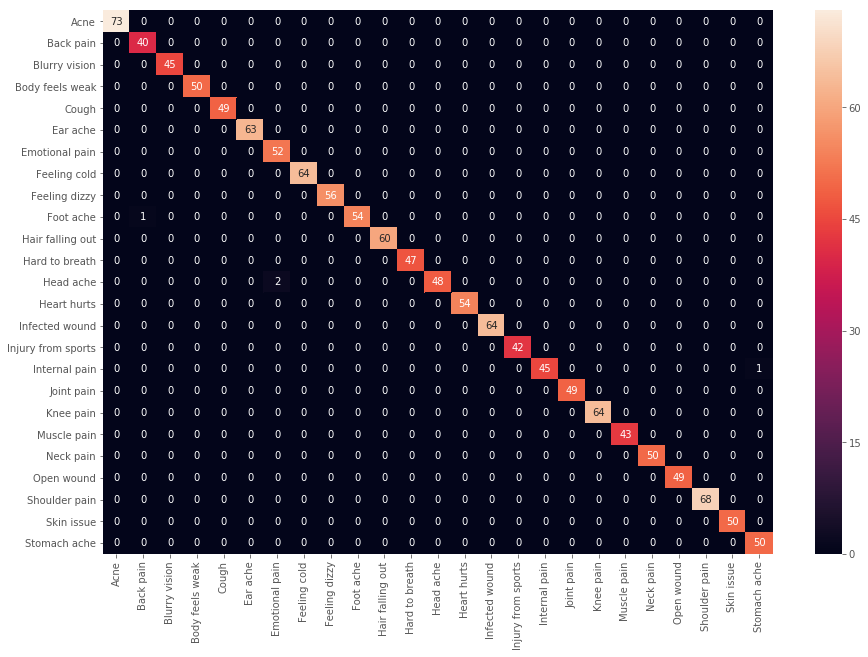

In [22]:
model_cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(model.predict(x_phrase_test),axis=1))

fig = plt.figure(figsize=(15,10))
sns.heatmap(model_cm, annot=True, xticklabels=enc.categories_[0].tolist(), yticklabels=enc.categories_[0].tolist())

The confusion matrix shows that the RNN was able to accurately classify the phrases into the categories! The accuracy looks a little decieving but that's what you get when you havesqueaky clean, short text samples and plenty of training data!

### Building the WAV Model

The WAV model wasn't successful. It was VERY difficult to get the data in a format that would fit in the kaggle kernal and even once I thought I did that, the model wasn't able to identify any more accurately than random. I've left the code in but I will not run it in the kernal.

In [23]:
from keras.constraints import max_norm
def build_wav_model(filters, input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters, 2, 2, activation='relu', padding="same", input_shape=input_shape, kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Conv2D(int(filters / 2), 2, 2, activation='relu', padding="same"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(.2))
    #model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(unique_prompts, activation='softmax'))
    return model

wav_model = build_wav_model(
    filters = 32,
    input_shape = x_wav_train[0].shape)

adam_opt = Adam(lr=0.001)

wav_model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])
wav_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 109, 112, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 56, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 28, 16)        2064      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 14, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 14, 16)        64        
_________________________________________________________________
flatten (Flatten)            (None, 2912)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2912)             

In [24]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, min_delta=.005)

callbacks_list = [earlystop_callback]

#history = wav_model.fit(x_wav_train, y_train,epochs=15, batch_size=20, validation_split = .2,callbacks=callbacks_list)

When this code was run, it was not able to identify phrases with any more accuracy than random.

I'll try the AlexNet architecture to see if it was a problem with the NN.

In [25]:
def alexnet(in_shape=x_wav_train[0].shape, n_classes=unique_prompts, opt='sgd'):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(in_shape))
    model.add(tf.keras.layers.Conv2D(96,11, strides=4, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(3, 2))
    model.add(tf.keras.layers.Conv2D(256,5, strides=1, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(3, 2))
    model.add(tf.keras.layers.Conv2D(384, 3, strides=1, padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2D(256, 3, strides=1, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(3, 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

    return model

In [26]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, min_delta=.005)

callbacks_list = [earlystop_callback]

alexnet_model = alexnet()

alexnet_model.compile(loss="categorical_crossentropy", optimizer='adam',
	              metrics=["accuracy"])

#history = alexnet_model.fit(x_wav_train, y_train,epochs=15, batch_size=20, validation_split = .2,callbacks=callbacks_list)

It wasn't a problem with the network :') 

### Conclusions

- The text phrases were able to be tokenized and fed into an LSTM which classified them into their corresponding prompts very accurately.

- The .wav files are difficult to work with.
    - Feeding the data derived directly from the file isn't an option as its nearly 100k lines per file.
    - Convert the sound data into spectrograms and then feeding the images into a CNN did not allow for classification. 
    
#### Things to Improve

- Try different methods of working with the .wav files. 
    - Larger images may allow for higher information transcirption density but the file size is a big issue. 
    - Converting them to a different type of image may be necessary.
    - Working with the raw sound data rather than an image representation would be ideal but would require a "big data" approach.